## MOFAtalk

In [1]:
import os

In [2]:
data_dir = os.path.join('..', '..', 'data', 'kidney_injury')

In [3]:
# columns of interest
sample_key = "ident"
groupby = "cell_type"
condition_key = "Group"

## Setup Environment

In [4]:
import numpy as np
import pandas as pd

import scanpy as sc

In [5]:
import mofax as mofa
import muon as mu
import decoupler as dc

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import liana as li
import plotnine as p9

In [7]:
li.__version__

'1.0.0a0'

Load object

In [8]:
adata = sc.read_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

In [9]:
adata.obs.sort_values("cell_type")

,orig.ident,nCount_RNA,nFeature_RNA,Group,Replicates,cell_state,ident,cell_type,full_name,n_genes,keep_sum,keep_min,keep_celltype
IRI12h2_CAACTAGGTTTACTCT,IRI12h2,1428.0,532,12hours,2,CNT,IRI12h2,CNT,Connecting tubule,532,24,True,True
IRIsham1b2_CACAGGCTCAAGGTAA,IRIsham1b2,1331.0,579,Control,1_2,CNT,IRIsham1b2,CNT,Connecting tubule,579,24,True,True
IRI14d1b2_ATGGGAGTCTGCGGCA,IRI14d1b2,1279.0,535,14days,1_2,CNT,IRI14d1b2,CNT,Connecting tubule,535,24,True,True
IRIsham2_GACAGAGTCAACCAAC,IRIsham2,1042.0,532,Control,2,CNT,IRIsham2,CNT,Connecting tubule,532,24,True,True
IRI4h3_AAGGTTCTCCAATGGT,IRI4h3,1446.0,553,4hours,3,CNT,IRI4h3,CNT,Connecting tubule,553,24,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
IRI6w3_ATCTGCCGTGGTGTAG,IRI6w3,1120.0,577,6weeks,3,Uro,IRI6w3,Uro,Urothelial cell,577,23,True,True
IRIsham1b1_CGTCTACAGACGCTTT,IRIsham1b1,1218.0,718,Control,1_1,Uro,IRIsham1b1,Uro,Urothelial cell,718,23,True,True
IRI2d1b1_CGTTAGAAGCTCCTTC,IRI2d1b1,1560.0,667,2days,1_1,Uro,IRI2d1b1,Uro,Urothelial cell,667,23,True,True
IRIsham1b2_CGCTTCATCCTTGACC,IRIsham1b2,1794.0,776,Control,1_2,Uro,IRIsham1b2,Uro,Urothelial cell,776,23,True,True


In [10]:
adata.obs[groupby].value_counts()

PT         50159
MTAL       13750
CTAL        9904
EC          9660
PC          8407
DCT         7500
DTL-ATL     4924
CNT         4578
Fib         4350
MO          3036
ICA         2920
ICB         1974
DCT-CNT     1682
Uro         1167
Pod          771
Tcell        617
PEC          518
Per          396
Name: cell_type, dtype: int64

In [11]:
adata.uns.keys()

dict_keys(['X_name', 'cell_type_colors', 'liana_res', 'log1p', 'neighbors', 'pca', 'umap'])

In [12]:
adata.obs[[groupby, 'full_name']].drop_duplicates().sort_values('cell_type')

,cell_type,full_name
IRI4h1_AAATGCCTCAAACCAC,CNT,Connecting tubule
IRI4h1_AAACCTGAGATCTGCT,CTAL,Thick ascending limb of loop of Henle
IRI4h1_AAACCTGCACCAACCG,DCT,Distal convoluted tubule
IRI4h1_AAACCTGTCGTCGTTC,DCT-CNT,DCT-CNT
IRI4h1_AAAGCAACATCGGGTC,DTL-ATL,DTL-ATL (thin ascending limb of loop of Henle)
IRI4h1_AAACCTGAGTGTTAGA,EC,Epithelial cells
IRI4h1_ACACTGAAGAGAGCTC,EC,Epithelial cell
IRI4h1_AAACCTGGTAGCGCTC,Fib,Fibroblast
IRI4h1_AAACCTGCAGGGAGAG,ICA,Intercalated cell of collecting duct
IRI4h1_AAACGGGTCTGAGTGT,ICB,Type B intercalated cell


Exclude Urothelial cells -> they are distant from most other cells

In [16]:
adata = adata[~adata.obs[groupby].isin(['Uro'])].copy()

In [17]:
adata.obs[groupby].value_counts()

PT         50159
MTAL       13750
CTAL        9904
EC          9660
PC          8407
DCT         7500
DTL-ATL     4924
CNT         4578
Fib         4350
MO          3036
ICA         2920
ICB         1974
DCT-CNT     1682
Pod          771
Tcell        617
PEC          518
Per          396
Name: cell_type, dtype: int64

## Run LIANA

In [19]:
li.method.rank_aggregate.by_sample(adata,
                                   groupby=groupby,
                                   sample_key=sample_key,
                                   resource_name='mouseconsensus',
                                   use_raw=False,
                                   verbose=True,
                                   n_perms=None,
                                   return_all_lrs=False
                                   )

Now running: IRIsham3: 100%|██████████| 24/24 [07:27<00:00, 18.63s/it]


In [20]:
adata.write_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

In [21]:
adata.uns['liana_res']['ident'].nunique()

24

## Run MOFA

In [8]:
adata = sc.read_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

In [9]:
score_key = 'magnitude_rank'

Build Views

In [10]:
mdata = li.multi.lrs_to_views(adata,
                              sample_key=sample_key,
                              score_key=score_key,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.25, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 25, # minimum number of interactions to keep a view
                              samples_per_view = 5, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = np.nan, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 128/128 [00:00<00:00, 216.34it/s]


In [11]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           outfile='models/mofatalk.h5ad',
           n_factors=5,
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='PEC&CTAL' group='group1' with N=24 samples and D=17 features...
Loaded view='PEC&MTAL' group='group1' with N=24 samples and D=29 features...
Loaded view='PEC&Per' group='group1' with N=24 samples and D=48 features...
Loaded view='PEC&PC' group='group1' with N=24 samples and D=22 features...
Loaded view='PEC&ICB' group='group1' with N=24 samples and D=18 features...


In [12]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=['Group'])
# re-order Groups
factor_scores['Group'] = factor_scores['Group'].astype('category')
factor_scores['Group'] = factor_scores['Group'].cat.reorder_categories(['Control', '4hours','12hours',  '2days', '14days', '6weeks'])
factor_scores.head()

,ident,Factor1,Factor2,Factor3,Factor4,Factor5,Group
0,IRI12h1b1,0.221781,-0.019267,-0.007614,-0.005908,0.0,12hours
1,IRI12h1b2,0.221089,-0.015401,-0.008108,-0.007180,0.0,12hours
2,IRI12h2,0.225568,-0.014794,-0.008239,-0.006713,0.0,12hours
3,IRI12h3,0.214938,-0.014782,-0.008637,-0.007098,0.0,12hours
4,IRI14d1b1,-0.088504,-0.018333,-0.009207,-0.006961,0.0,14days


In [13]:
# Kruskal Wallis test
from scipy.stats import kruskal

In [14]:
# Extract the values for each group
groups = []
for group_name, group_data in factor_scores.groupby('Group'):
    groups.append(group_data['Factor1'].values)

# Perform the Kruskal-Wallis test
statistic, p_value = kruskal(*groups)

# Print the test results
print("Kruskal-Wallis Test")
print("Statistic:", statistic)
print("P-value:", p_value)

Kruskal-Wallis Test
Statistic: 15.98266666666666
P-value: 0.006893735998033352


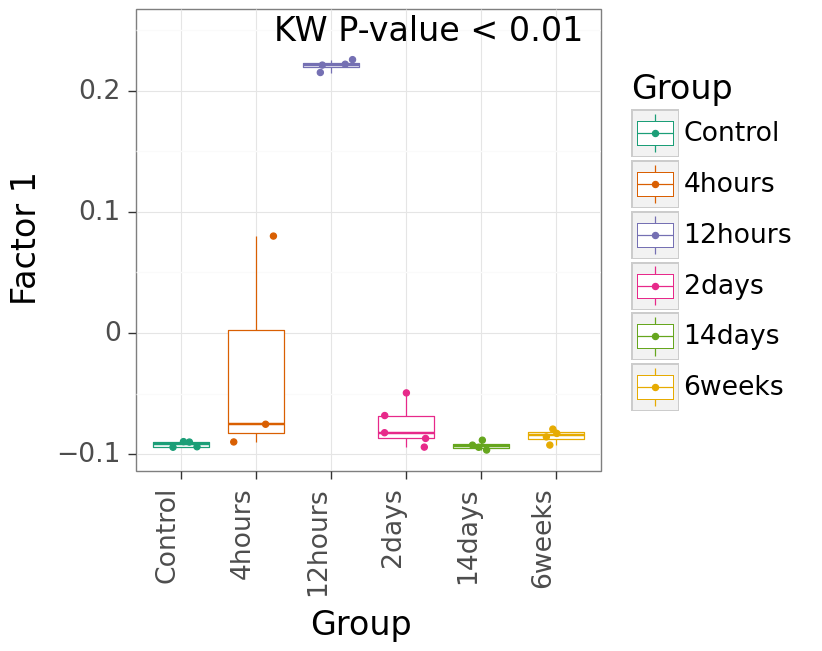

<ggplot: (8734259719733)>

In [15]:
# scatterplot
(p9.ggplot(factor_scores) +
 p9.aes(x='Group', colour='Group', y='Factor1') +
 p9.geom_boxplot() +
 p9.geom_jitter(size=2, width=0.3) +
 p9.theme_bw(base_size=24) +
 p9.theme(figure_size=(6, 6)) + 
 p9.labs(x='Group', y='Factor 1') +
 # rotate x-axis labels
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=1)) +
 # Dark2 set 
 p9.scale_color_brewer(type='qual', palette='Dark2') +
 # add p-value to top-right
 p9.annotate('text', x=4.3, y=0.25, label=f'KW P-value < {np.ceil(p_value * 100) / 100}', size=24)
 
 )

Plot R-sq

In [16]:
model = mofa.mofa_model("models/mofatalk.h5ad")
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 24
Features: 1954
Groups: group1 (24)
Views: CNT&DTL-ATL (19), CNT&Fib (26), CNT&PEC (33), CNT&PT (18), CNT&Per (17), CNT&Pod (23), CTAL&DTL-ATL (18), CTAL&Fib (22), CTAL&PEC (27), CTAL&PT (16), CTAL&Per (15), CTAL&Pod (17), DCT&DTL-ATL (21), DCT&Fib (23), DCT&PEC (25), DCT&PT (14), DCT&Per (12), DCT&Pod (21), DCT-CNT&Fib (25), DCT-CNT&PEC (27), DCT-CNT&Pod (17), DTL-ATL&DTL-ATL (18), DTL-ATL&Fib (24), DTL-ATL&PEC (29), DTL-ATL&PT (17), DTL-ATL&Per (23), DTL-ATL&Pod (22), EC&Fib (11), EC&PEC (8), EC&Per (6), EC&Pod (13), Fib&DCT-CNT (14), Fib&DTL-ATL (27), Fib&Fib (42), Fib&MTAL (19), Fib&PEC (44), Fib&PT (25), Fib&Per (32), Fib&Pod (40), ICA&Fib (15), ICA&Pod (15), ICB&Fib (21), ICB&PEC (24), ICB&Pod (15), MTAL&DTL-ATL (15), MTAL&Fib (26), MTAL&PEC (19), MTAL&PT (17), MTAL&Per (15), PC&DTL-ATL (23), PC&Fib (28), PC&PEC (30), PC&PT (23), PC&Per (22), PC&Pod (23), PEC&CNT (14), PEC&CTAL (17), PEC&DCT (18), PEC&DCT-CNT (22), PEC&DTL-ATL (34), P

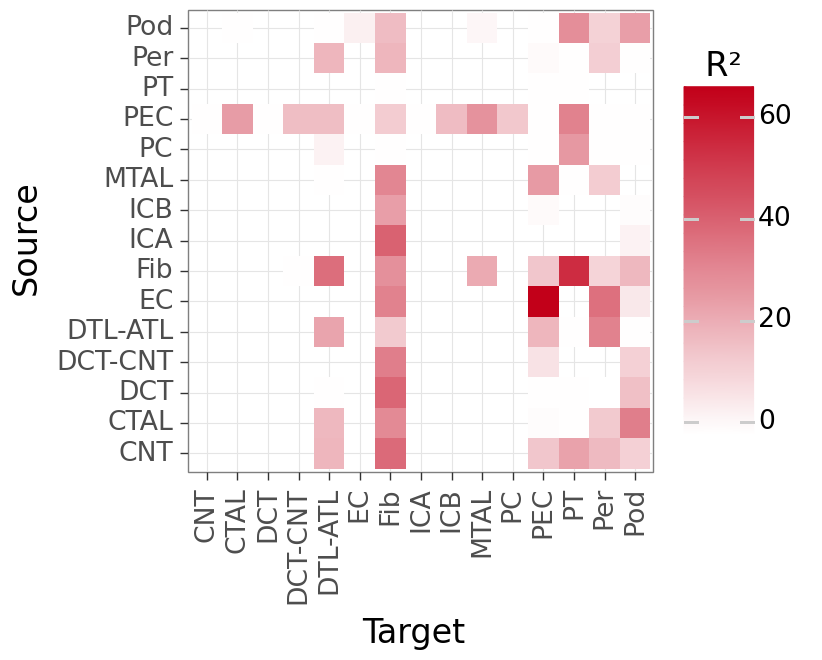

<ggplot: (8734258743498)>

In [17]:
# get variance explained by view and factor
rsq = model.get_r2()
factor1_rsq = rsq[rsq['Factor']=='Factor1']
# separate view column
factor1_rsq[['source', 'target']] = factor1_rsq['View'].str.split('&', 1, expand=True)

(p9.ggplot(factor1_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
 p9.scale_fill_gradient2(low='white', high='#c20019') +
 p9.theme_bw(base_size=24) +
 # rotate X axis
 p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(6, 6)) +
 p9.labs(x='Target', y='Source', fill='  R²')
 )

Average R2 per source & target

In [22]:
factor1_rsq['R2'].mean()

13.504161972398885

In [37]:
# mean R2 and std for factor1
source_rsq = factor1_rsq.groupby('source').agg({'R2': ['mean', 'std']}).sort_values(('R2', 'mean'), ascending=False)
source_rsq

R2           
              mean        std
source                       
EC       34.360509  23.878267
Fib      22.622524  16.348104
ICA      21.249511  25.699804
CNT      20.299012   9.293882
DCT-CNT  17.055495  13.281675
CTAL     15.621668  13.820148
DTL-ATL  14.367167  12.572105
MTAL     13.674919  14.067834
PEC      10.642795  11.382548
Pod       9.723035  11.075584
DCT       8.906439  15.730920
ICB       8.683529  13.491364
Per       8.387539   9.012578
PC        4.868470  10.288334
PT        0.000774   0.000621

In [38]:
# mean R2 and std for factor1
target_rsq = factor1_rsq.groupby('target').agg({'R2': ['mean', 'std']}).sort_values(('R2', 'mean'), ascending=False)
target_rsq

R2           
              mean        std
target                       
Fib      23.454755  12.779219
MTAL     17.068603  13.150821
ICB      16.848081        NaN
PT       14.681609  18.411441
PC       13.613130        NaN
DTL-ATL  13.332570  12.156769
Per      13.158736  11.928605
CTAL     12.564927  17.652230
PEC      10.430499  17.572635
Pod       9.566206  10.664355
DCT-CNT   8.029917  11.355579
EC        1.853456   2.618304
DCT       0.017407        NaN
CNT       0.006720        NaN
ICA       0.000029        NaN

In [54]:
top_sources = source_rsq[source_rsq['R2']['mean'] > 15].index.values
top_targets = target_rsq.head(5).index.values

In [60]:
top_sources

array(['EC', 'Fib', 'ICA', 'CNT', 'DCT-CNT', 'CTAL'], dtype=object)

In [55]:
factor1_rsq.sort_values("R2", ascending=False).head(10)

,Factor,View,Group,R2,source,target
79,Factor1,EC&PEC,group1,64.220636,EC,PEC
32,Factor1,Fib&PT,group1,52.756286,Fib,PT
27,Factor1,ICA&Fib,group1,39.422017,ICA,Fib
67,Factor1,DCT&Fib,group1,38.200949,DCT,Fib
56,Factor1,CNT&Fib,group1,37.472814,CNT,Fib
47,Factor1,Fib&DTL-ATL,group1,36.341871,Fib,DTL-ATL
76,Factor1,EC&Per,group1,36.031851,EC,Per
13,Factor1,CTAL&Pod,group1,32.535246,CTAL,Pod
54,Factor1,DCT-CNT&Fib,group1,32.136411,DCT-CNT,Fib
48,Factor1,DTL-ATL&Per,group1,31.566396,DTL-ATL,Per


In [56]:
adata.obs[[groupby, "full_name"]].drop_duplicates()

,cell_type,full_name
IRI4h1_AAACCTGAGATCTGCT,CTAL,Thick ascending limb of loop of Henle
IRI4h1_AAACCTGAGATTACCC,PT,Proximal tubule
IRI4h1_AAACCTGAGTGTTAGA,EC,Epithelial cells
IRI4h1_AAACCTGCACCAACCG,DCT,Distal convoluted tubule
IRI4h1_AAACCTGCAGCCTGTG,MTAL,medullary thick ascending limb
IRI4h1_AAACCTGCAGGGAGAG,ICA,Intercalated cell of collecting duct
IRI4h1_AAACCTGGTAGCGCTC,Fib,Fibroblast
IRI4h1_AAACCTGTCGTCGTTC,DCT-CNT,DCT-CNT
IRI4h1_AAACGGGAGCATGGCA,MO,Macrophages
IRI4h1_AAACGGGGTGCAACGA,PC,Principal cells


Check LR loadings

In [57]:
lr_loadings = li.ut.get_variable_loadings(mdata,
                                          varm_key='LFs',
                                          view_separator=':',
                                          pair_separator="&",
                                          variable_separator="^"
                                          ) # get loadings for factor 1
lr_loadings['size'] = 3
lr_loadings.head()

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,size
1135,Tnc,Sdc4,Fib,DTL-ATL,3.206094,0.030733,0.004623,-0.120384,0.0,3
1344,Slit2,Robo2,CNT,Fib,-3.174712,0.866670,-0.003596,0.044211,0.0,3
1588,Slit2,Robo2,DCT,Fib,-3.172455,0.651905,-0.012345,-0.019762,0.0,3
1662,Shank2,Cftr,MTAL,PEC,-3.167403,6.256488,0.023604,0.016892,0.0,3
1665,Spp1,Itgav_Itgb1,MTAL,PEC,3.059505,-1.297114,-0.020138,-0.012189,0.0,3


In [58]:
lr_loadings.sort_values('Factor1', ascending=False, key=abs)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,size
1135,Tnc,Sdc4,Fib,DTL-ATL,3.206094e+00,3.073332e-02,4.623100e-03,-1.203838e-01,0.0,3
1344,Slit2,Robo2,CNT,Fib,-3.174712e+00,8.666705e-01,-3.595545e-03,4.421061e-02,0.0,3
1588,Slit2,Robo2,DCT,Fib,-3.172455e+00,6.519045e-01,-1.234473e-02,-1.976236e-02,0.0,3
1662,Shank2,Cftr,MTAL,PEC,-3.167403e+00,6.256488e+00,2.360412e-02,1.689249e-02,0.0,3
1665,Spp1,Itgav_Itgb1,MTAL,PEC,3.059505e+00,-1.297114e+00,-2.013805e-02,-1.218919e-02,0.0,3
...,...,...,...,...,...,...,...,...,...,...
11,Ncam1,Fgfr2,PEC,CTAL,3.678343e-08,2.367751e-07,2.627594e-07,-8.721419e-07,0.0,3
141,Ncam1,Fgfr2,PEC,CNT,-1.961308e-08,-5.424818e-09,3.857233e-09,2.019983e-08,0.0,3
34,Ncam1,Fgfr2,PEC,MTAL,1.381987e-08,1.209971e-07,4.451164e-07,1.463304e-07,0.0,3
125,Ncam1,Fgfr2,PEC,ICB,-6.289745e-09,-4.179359e-08,1.034989e-07,4.517279e-08,0.0,3


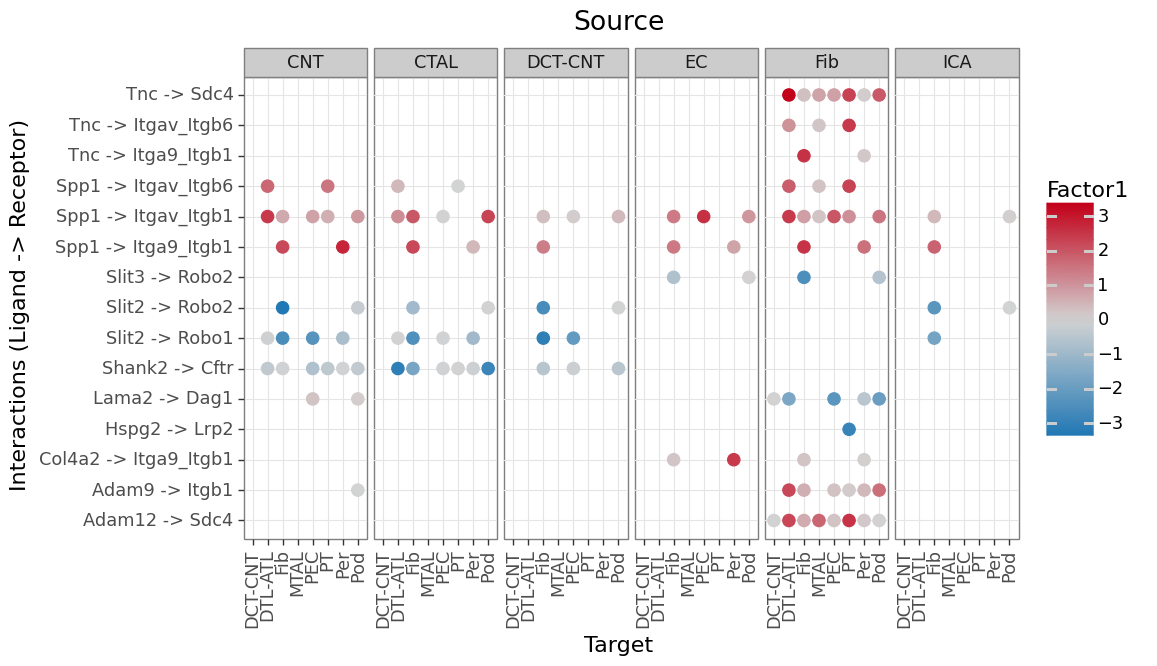

<ggplot: (8734144602917)>

In [63]:
my_plot = li.pl.dotplot(liana_res = lr_loadings,
                        size='size',
                        colour='Factor1',
                        orderby='Factor1',
                        orderby_ascending=False,
                        orderby_absolute=True,
                        top_n=15,
                        source_labels=top_sources,
                        # target_labels=top_targets,
                        size_range=(0.1, 4.5)
                        )
# change colour, with mid as white
(my_plot + 
 p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019') + 
 p9.theme_bw(base_size=16) +
 p9.theme(figure_size=(10, 6)) +
 p9.theme(axis_text_x=p9.element_text(angle=90)) +
 # remove size from legend
 p9.guides(size=False)
)

In [ ]:
model.close()